# Advent of Code 2018

## Norvig's Utilities

In [1]:
# Python 3.x Utility Functions

%matplotlib inline
import matplotlib.pyplot as plt

import os
import urllib.request

import re
import numpy as np
import math
import random
import time

from collections import Counter, defaultdict, namedtuple, deque, abc, OrderedDict
from functools   import lru_cache, reduce
from statistics  import mean, median, mode, stdev, variance
from itertools   import (permutations, combinations, chain, cycle, product, islice, 
                         takewhile, zip_longest, count as count_from)
from heapq       import heappop, heappush
from numba       import jit

letters  = 'abcdefghijklmnopqrstuvwxyz'

cache = lru_cache(None)

cat = ''.join

Ø   = frozenset() # Empty set
inf = float('inf')
BIG = 10 ** 999

################ Functions for Input, Parsing
def Input(day, line_parser=str.strip, file_template='data/advent2018/input{}.txt'):
    "For this day's input file, return a tuple of each line parsed by `line_parser`."
    return mapt(line_parser, open(file_template.format(day)))
    
def integers(text): 
    "A tuple of all integers in a string (ignore other characters)."
    return mapt(int, re.findall(r'-?\d+', text))
        
def error(err=RuntimeError, *args): raise err(*args)

################ Functions on Iterables

def first(iterable, default=None): 
    "The first item in an iterable, or default if it is empty."
    return next(iter(iterable), default)

def first_true(iterable, pred=None, default=None):
    """Returns the first true value in the iterable.
    If no true value is found, returns *default*
    If *pred* is not None, returns the first item
    for which pred(item) is true."""
    # first_true([a,b,c], default=x) --> a or b or c or x
    # first_true([a,b], fn, x) --> a if fn(a) else b if fn(b) else x
    return next(filter(pred, iterable), default)

def nth(iterable, n, default=None):
    "Returns the nth item of iterable, or a default value"
    return next(islice(iterable, n, None), default)

def upto(iterable, maxval):
    "From a monotonically increasing iterable, generate all the values <= maxval."
    # Why <= maxval rather than < maxval? In part because that's how Ruby's upto does it.
    return takewhile(lambda x: x <= maxval, iterable)

identity = lambda x: x

def groupby(iterable, key=identity):
    "Return a dict of {key(item): [items...]} grouping all items in iterable by keys."
    groups = defaultdict(list)
    for item in iterable:
        groups[key(item)].append(item)
    return groups

def grouper(iterable, n, fillvalue=None):
    """Collect data into fixed-length chunks:
    grouper('ABCDEFG', 3, 'x') --> ABC DEF Gxx"""
    args = [iter(iterable)] * n
    return zip_longest(*args, fillvalue=fillvalue)

def overlapping(iterable, n):
    """Generate all (overlapping) n-element subsequences of iterable.
    overlapping('ABCDEFG', 3) --> ABC BCD CDE DEF EFG"""
    if isinstance(iterable, abc.Sequence):
        yield from (iterable[i:i+n] for i in range(len(iterable) + 1 - n))
    else:
        result = deque(maxlen=n)
        for x in iterable:
            result.append(x)
            if len(result) == n:
                yield tuple(result)
                
def pairwise(iterable):
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    return overlapping(iterable, 2)

def sequence(iterable, type=tuple):
    "Coerce iterable to sequence: leave alone if already a sequence, else make it `type`."
    return iterable if isinstance(iterable, abc.Sequence) else type(iterable)

def join(iterable, sep=''):
    "Join the items in iterable, converting each to a string first."
    return sep.join(map(str, iterable))
                
def powerset(iterable):
    "Yield all subsets of items."
    items = list(iterable)
    for r in range(len(items)+1):
        for c in combinations(items, r):
            yield c
            
def quantify(iterable, pred=bool):
    "Count how many times the predicate is true."
    return sum(map(pred, iterable))

def length(iterable):
    "Same as len(list(iterable)), but without consuming memory."
    return sum(1 for _ in iterable)

def shuffled(iterable):
    "Create a new list out of iterable, and shuffle it."
    new = list(iterable)
    random.shuffle(new)
    return new
    
flatten = chain.from_iterable

################ Functional programming

def mapt(fn, *args): 
    "Do a map, and make the results into a tuple."
    return tuple(map(fn, *args))

def map2d(fn, grid):
    "Apply fn to every element in a 2-dimensional grid."
    return tuple(mapt(fn, row) for row in grid)

def repeat(n, fn, arg, *args, **kwds):
    "Repeat arg = fn(arg) n times, return arg."
    return nth(repeatedly(fn, arg, *args, **kwds), n)

def repeatedly(fn, arg, *args, **kwds):
    "Yield arg, fn(arg), fn(fn(arg)), ..."
    yield arg
    while True:
        arg = fn(arg, *args, **kwds)
        yield arg
        
def compose(f, g): 
    "The function that computes f(g(x))."
    return lambda x: f(g(x))

################ Making immutable objects
            
class Set(frozenset):
    "A frozenset, but with a prettier printer."
    def __repr__(self): return '{' + join(sorted(self), ', ') + '}'
    
def canon(items, typ=None):
    "Canonicalize these order-independent items into a hashable canonical form."
    typ = typ or (cat if isinstance(items, str) else tuple)
    return typ(sorted(items))
            
################ Math Functions
            
def transpose(matrix): return tuple(zip(*matrix))

def isqrt(n):
    "Integer square root (rounds down)."
    return int(n ** 0.5)

def ints(start, end, step=1):
    "The integers from start to end, inclusive: range(start, end+1)"
    return range(start, end + 1, step)

def floats(start, end, step=1.0):
    "Yield floats from start to end (inclusive), by increments of step."
    m = (1.0 if step >= 0 else -1.0)
    while start * m <= end * m:
        yield start
        start += step
        
def multiply(numbers):
    "Multiply all the numbers together."
    result = 1
    for n in numbers:
        result *= n
    return result

import operator as op

operations = {'>': op.gt, '>=': op.ge, '==': op.eq,
              '<': op.lt, '<=': op.le, '!=': op.ne,
              '+': op.add, '-': op.sub, '*': op.mul, 
              '/': op.truediv, '**': op.pow}

################ 2-D points implemented using (x, y) tuples

def X(point): return point[0]
def Y(point): return point[1]

origin = (0, 0)
HEADINGS = UP, LEFT, DOWN, RIGHT = (0, -1), (-1, 0), (0, 1), (1, 0)

def turn_right(heading): return HEADINGS[HEADINGS.index(heading) - 1]
def turn_around(heading):return HEADINGS[HEADINGS.index(heading) - 2]
def turn_left(heading):  return HEADINGS[HEADINGS.index(heading) - 3]

def add(A, B): 
    "Element-wise addition of two n-dimensional vectors."
    return mapt(sum, zip(A, B))

def neighbors4(point): 
    "The four neighboring squares."
    x, y = point
    return (          (x, y-1),
            (x-1, y),           (x+1, y), 
                      (x, y+1))

def neighbors8(point): 
    "The eight neighboring squares."
    x, y = point 
    return ((x-1, y-1), (x, y-1), (x+1, y-1),
            (x-1, y),             (x+1, y),
            (x-1, y+1), (x, y+1), (x+1, y+1))

def cityblock_distance(P, Q=origin): 
    "Manhatten distance between two points."
    return sum(abs(p - q) for p, q in zip(P, Q))

def distance(P, Q=origin): 
    "Straight-line (hypotenuse) distance between two points."
    return sum((p - q) ** 2 for p, q in zip(P, Q)) ** 0.5

def king_distance(P, Q=origin):
    "Number of chess King moves between two points."
    return max(abs(p - q) for p, q in zip(P, Q))

################ Debugging 

def trace1(f):
    "Print a trace of the input and output of a function on one line."
    def traced_f(*args):
        result = f(*args)
        print('{}({}) = {}'.format(f.__name__, ', '.join(map(str, args)), result))
        return result
    return traced_f

def grep(pattern, iterable):
    "Print lines from iterable that match pattern."
    for line in iterable:
        if re.search(pattern, line):
            print(line)
            
class Struct:
    "A structure that can have any fields defined."
    def __init__(self, **entries): self.__dict__.update(entries)
    def __repr__(self): 
        fields = ['{}={}'.format(f, self.__dict__[f]) 
                  for f in sorted(self.__dict__)]
        return 'Struct({})'.format(', '.join(fields))

################ A* and Breadth-First Search (tracking states, not actions)

def always(value): return (lambda *args: value)

def Astar(start, moves_func, h_func, cost_func=always(1)):
    "Find a shortest sequence of states from start to a goal state (where h_func(s) == 0)."
    frontier  = [(h_func(start), start)] # A priority queue, ordered by path length, f = g + h
    previous  = {start: None}  # start state has no previous state; other states will
    path_cost = {start: 0}     # The cost of the best path to a state.
    Path      = lambda s: ([] if (s is None) else Path(previous[s]) + [s])
    while frontier:
        (f, s) = heappop(frontier)
        if h_func(s) == 0:
            return Path(s)
        for s2 in moves_func(s):
            g = path_cost[s] + cost_func(s, s2)
            if s2 not in path_cost or g < path_cost[s2]:
                heappush(frontier, (g + h_func(s2), s2))
                path_cost[s2] = g
                previous[s2] = s

def bfs(start, moves_func, goals):
    "Breadth-first search"
    goal_func = (goals if callable(goals) else lambda s: s in goals)
    return Astar(start, moves_func, lambda s: (0 if goal_func(s) else 1))

## Utility Functions

In [2]:
from datetime import datetime, date, time, timedelta

Point2D = namedtuple('Point','x y')
Rect = namedtuple('Rect', 'p w h')
    
def smult(s, t):
    return tuple(s * x for x in t)

## Day 1: Chronal Calibration

In [3]:
data1 = Input(1, int)
sum(data1)

595

### Part Two

In [4]:
def first_repeat(data):
    current, freqs = 0, {0}
    for f in data:
        current += f
        if current in freqs:
            return current
        freqs.add(current)

first_repeat(cycle(data1))

80598

## Day 2: Inventory Management System

In [5]:
data2 = Input(2)

def two_three(str):
    c = Set(Counter(str).values())
    return (2 in c, 3 in c)

def check_sum(data): return multiply(reduce(lambda p,t: add(p, two_three(t)), data, (0,0)))

check_sum(data2)

6474

### Part Two

In [6]:
def diff(s1, s2): return sum(x[0] != x[1] for x in zip(s1, s2))

def common(data):
    d = sorted(data)
    a, b = first(p for p in pairwise(d) if diff(p[0], p[1]) == 1)
    return cat(a[i] for i in range(len(a)) if a[i] == b[i])
    
common(data2)

'mxhwoglxgeauywfkztndcvjqr'

##  Day 3: No Matter How You Slice It

In [7]:
data3 = Input(3, integers)

def dim(l): return (Point2D(l[1], l[2]), Point2D(l[1] + l[3], l[2] + l[4]))

def counts(data):
    ds = map(dim, data)
    c = Counter()
    for d in ds:
        for i in range(d[0].x + 1, d[1].x + 1):
            for j in range(d[0].y + 1, d[1].y + 1):
                c[(i,j)] += 1
    return sum(1 for x in c.values() if x > 1)
    
counts(data3)

104126

### Part Two

In [8]:
def separate(d1, d2):
    p = Point2D(d1[1], d1[2])
    q = Point2D(d2[1], d2[2])
    pw, ph = d1[3], d1[4]
    qw, qh = d2[3], d2[4]
    return p.x > q.x + qw or p.x + pw < q.x or p.y > q.y + qh or p.y + ph < q.y
    
def overlaps(d, ds):
    count = 0
    for x in ds:
        if not separate(d, x):
            if count == 1: return True
            else: count += 1
    return False
    
def intact(data):
    for d in data:
        if not overlaps(d, data):
            return d
        

intact(data3)

(695, 337, 825, 27, 17)

## Day 4: Repose Record

In [9]:
def parse4(t):
    result = []
    t1 = map(lambda x: x.strip('['), t)
    t2 = map(lambda x: x.replace(']', ''), t1)
    t3 = map(lambda x: x.split(), t2)
    for r in t3:
        r[0] = date(*map(int, r[0].split('-')))
        h, m = r[1].split(':')
        if h == '23':
            r[1] = -1
        else:
            r[1] = int(m)
        result.append(r)
    guard = ''
    for r in result:
        if r[2] == 'Guard':
            guard = r[3]
        elif r[2] == 'falls':
            r[2] = guard
            r[3] = 'sleep'
        elif r[2] == 'wakes':
            r[2]= guard
            r[3] = 'wake'
        else: r = 'ERROR'
    result = filter(lambda x: x[2] != 'Guard', result)
    return list(result)
        
data4 = parse4(sorted(Input(4)))

def mkdict(data):
    d = dict()
    sleep = None
    for r in data:
        if r[3] == 'sleep':
            sleep = r[1]
        else:
            if r[2] in d:
                d[r[2]].append((sleep, r[1]))
            else:
                d[r[2]] = [(sleep, r[1])]
    return d
    
def mins(xs):
    total = 0
    for x in xs:
        total += x[1] - x[0]
    return total
    
def deltadict(d):
    newdict = dict()
    for k, v in d.items():
        newdict[k] = mins(v)
    return newdict

def sleeper(data):
    d = mkdict(data)
    d1 = deltadict(d)
    m = 0
    km = ''
    for k, v in d1.items():
        if v > m: 
            m = v
            km = k
    return km, d[km]

def counter(xs):
    c = Counter()
    for x in xs:
        for i in range(x[0],x[1]):
            c[i] += 1
    return c
        
k , d = sleeper(data4)
m = counter(d).most_common()[0]
print(k, m[0], int(k.lstrip('#')) * m[0])


#179 50 8950


### Part Two

In [10]:
def sleepy_minute(data):
    d = mkdict(data)
    s = dict()
    for k, v in d.items():
        m = counter(v).most_common()[0]
        s[k] = m
    n = 0
    x = 0
    r = 0
    for k, v in s.items():
        if v[1] > x:
            n = int(k.lstrip('#'))
            x = v[1]
            r = v[0]
    return (n, r)

k, d = sleepy_minute(data4)
print(k, d, k*d)  

1783 44 78452


##  Day 5: Alchemical Reduction

In [11]:
data5 = cat(Input(5))

def opp_dict():
    caps = letters.upper()
    return dict(list(zip(letters, caps)) + list(zip(caps, letters)))

opps = opp_dict()

def react(s):
    left = deque()
    right = deque(s)
    while right:
        if left and left[-1] == opps[right[0]]:
            left.pop()
            right.popleft()
        else:
            left.append(right.popleft())
    return len(left)

react(data5)

9154

### Part 2

In [12]:
def improve(data):
    lens = []
    for c in letters:
        s = ''.join(filter(lambda x: x != c and x != c.upper(), data))
        d = dict(list(zip(s, s.upper())) + list(zip(s.upper(), s)))
        lens.append(react(s))
    return min(lens) 

improve(data5)

4556

## Day 6: Chronal Coordinates

In [13]:
data6 = Input(6,integers)

def closest(pt, xs):
    mins = []
    minx = inf
    ds = tuple(map(lambda x: cityblock_distance(pt, x), xs))
    for i in range(len(ds)):
        if ds[i] == minx:
            mins.append(xs[i])
        elif ds[i] < minx:
            minx = ds[i]
            mins = [xs[i]]
    if len(mins) == 1:
        return mins.pop(0)
    else: 
        return (0,0)

def chronal(data, s, x, y):
    result = {}
    for x in range(s, x):
        for y in range(s, y):
            result[(x, y)] = closest((x, y), data)
    return result
            
def count_values(d): return Counter(d.values())
        
def result6(data):
    maxX = reduce(max, map(X, data))
    maxY = reduce(max, map(Y, data))
    id1 = count_values(chronal(data, 1, maxX, maxY))
    id2 = count_values(chronal(data, 0, maxX + 1, maxY + 1))
    d = []
    for k, v in id1.items():
        if id1[k] == id2[k]:
            d.append(v)
    return max(d)
            
result6(data6)

3551

### Part Two

In [14]:
def dists(xs):
    ps = []
    for r in range(0, 342):
        for c in range(0, 355):
            ps.append(sum(map(lambda x: cityblock_distance((r, c), x), xs)))
    return len(list(filter(lambda y: y < 10000, ps)))

dists(data6)


42513

## Day 7: The Sum of Its Parts 

In [15]:
def parse7(x): 
    return re.findall(' ([A-Z]) ', x)

data7 = Input(7, parse7)

In [16]:
def indegree(graph, node):
    degree = 0
    for k, v in graph.items():
        if node in v:
            degree += 1
    return degree

def kahn(data):
    graph = defaultdict(list)
    for k, v in data:
        graph[k].append(v)
    L = []
    S = [k for k in graph if indegree(graph, k) == 0]
    while S:
        S.sort()
        n = S.pop(0)
        L.append(n)
        ms = graph[n]
        graph[n] = []
        for m in ms:
            if indegree(graph, m) == 0 and m not in S:
                S.append(m)
    return(join(L))
  
kahn(data7)

'BGJCNLQUYIFMOEZTADKSPVXRHW'

### Part Two

In [17]:
def step_time(c):
    return ord(c) - 4

def kahn2(data):
    graph = defaultdict(list)
    for k, v in data:
        graph[k].append(v)
        
    time = 0
    A5 = []
    S = [k for k in graph if indegree(graph, k) == 0]
    
    while S or A5:
        S.sort()
        while S and len(A5) < 5:
            c = S.pop(0)
            A5.append([c, step_time(c)])
        done = min(A5, key=lambda x: x[1])
        A5.remove(done)
        t = done[1]
        time += t
        for i in range(len(A5)):
            A5[i][1] = A5[i][1] - t
        ms = graph[done[0]]
        graph[done[0]] = []
        for m in ms:
            if indegree(graph, m) == 0 and m not in S:
                S.append(m)
    return time
    
kahn2(data7)

1017

## Day 8

In [18]:
data8 = integers(cat(Input(8)))

class Tree(object):
    def __init__(self):
        self.num_children = 0
        self.num_metadata = 0
        self.metadata = []
        self.children = []
        
def make_tree(data):
    n = data.pop(0)
    m = data.pop(0)
    tree = Tree()
    for i in range(n):
        tree.children.append(make_tree(data))
    for j in range(m):
        tree.metadata.append(data.pop(0))
    return tree
  
def sum_meta(tree):
    result = sum(tree.metadata)
    c = map(sum_meta, tree.children)
    return result + sum(c)
    
sum_meta(make_tree(list(data8)))

48443

### Part 2

In [19]:
def tree_value(tree):
    if not tree.children:
        return sum(tree.metadata)
    else:
        v = 0
        for m in tree.metadata:
            if m <= len(tree.children):
                v += tree_value(tree.children[m - 1])
        return v
             
tree_value(make_tree(list(data8)))

30063

## Day 9

In [20]:
def play(players, rounds):
    chain = deque([0])
    scores = defaultdict(int)
    
    for i in range(1, rounds + 1):
        if not i % 23 == 0:
            chain.rotate(-1)
            chain.append(i)
        else:
            chain.rotate(7)
            scores[i % players] += i + chain.pop()
            chain.rotate(-1)
    return max(scores.values())
        
play(441, 71032)

393229

### Part 2

In [21]:
play(441, 7103200)

3273405195

## Day 10: The Stars Align

10639


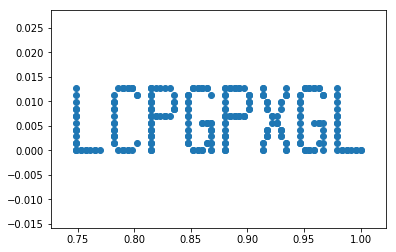

In [22]:
def tups(tuple4):
    a,b,c,d = tuple4
    return (a,b), (c,d)

data10 = mapt(tups, Input(10, integers))

def draw(points):
    x = mapt(X, points)
    y = mapt(Y, points)
    yMax = max(y)
    y = mapt(lambda a: yMax - a, y)
    plt.scatter(x, y)
    plt.show()
    
def move(pts, vels, n):
    def move_point(p, v): 
        return(add(p, smult(n, v)))
    return tuple(move_point(pts[i], vels[i]) for i in range(len(pts)))
      
def scale(pts):
    pts = list(pts)
    xs = mapt(X, pts)
    ys = mapt(Y, pts)
    xMax = max(xs)
    yMax = max(ys)
    xs1 = mapt(lambda a: a / xMax, xs)
    ys1 = mapt(lambda a: 0.25 * a / yMax, ys)
    return zip(xs1,ys1)

def yMetric(pts):
    return abs(max(mapt(Y,pts)) - min(mapt(Y,pts)))

def newton(fn, metric, epsilon, max_iter):
    guess = 0
    iter = 0
    while True:
        slope = metric(fn(guess + 1)) - metric(fn(guess))
        if abs(slope) <= epsilon or iter > max_iter:
            return guess
        else:
            iter += 1
            guess = guess - metric(fn(guess)) // slope
        
points = mapt(X, data10)
velocities = mapt(Y, data10)

def moveN(n):
    return move(points, velocities, n)

seconds = newton(moveN, yMetric, 1, 100)
print(seconds)
draw(tuple(scale(move(points, velocities, seconds))))

## Day 11: Chronal Charge

In [23]:
sn = 8772

def hundredths(n):
    ds = [int(j) for j in str(n)]
    if len(ds) < 3:
        return 0
    else: return ds[-3]

@cache
def power(x, y, s):
    rack_id = x + 10
    return hundredths((rack_id * y + s) * rack_id) - 5

def square(x, y, s):
    return sum(power(u, v, s) for u in (x, x+1, x+2) for v in (y, y+1, y+2))

def power_grid(s):
    max_power = -inf
    max_coords = (0, 0)
    for i in range(1, 298):
        for j in range(1, 298):
            p = square(i, j, s)
            if p > max_power:
                max_power = p
                max_coords = (i, j)
    return (max_coords, max_power)

power_grid(sn)

((235, 31), 31)

### Part 2

In [24]:
shape = np.arange(301 * 301, dtype=int)
shape = np.reshape(shape,(301,301))
regions = np.zeros_like(shape)

for i in range(1,301):
    for j in range(1,301):
        regions[i, j] = power(i, j, sn) + regions[i-1, j] + regions[i, j-1] - regions[i-1, j-1]

def best():
    max_coord = (0, 0, 0)
    max_value = -inf
    for n in range(1, 301):
        for x in range (n, 301):
            for y in range(n, 301):
                v = regions[x, y] - regions[x, y-n] - regions[x-n, y] + regions[x-n, y-n]
                if v >= max_value:
                    max_value = v
                    max_coord = (x-n+1, y-n+1, n)
    return(max_coord, max_value)

best()

((241, 65, 10), 73)

## Day 12: Subterranean Sustainability

In [25]:
data12 = Input(12)

state = '.' * 1000 + data12[0][15:] + '.' * 1000
data12 = data12[2:]
state, data12

def make_dict(data):
    rules = dict()
    for d in data:
        template, result = d.split(' => ')
        rules[template] = result
    return rules
    
def next_gen(state, dict):
    acc = []
    for i in range(2, len(state) - 2):
        acc.append(dict[state[i-2 : i+3]])
    return '..' + ''.join(acc) + '..'
    
def generation(state, data, n):
    dict = make_dict(data)
    new_state = state
    for i in range(n):
        new_state = next_gen(state, dict)
        state = new_state
    return state


g = generation(state, data12, 200)
c = 0
v = -1000
for i in range(0, len(g)):
    if g[i] == '#': 
        c += v
    v += 1
        
c


17549

At 200 generations 17549 increases 86 plants per generation so (50bln - 200) * 86 + 17549

## Day 13: Mine Cart Madness

In [26]:
data13 = mapt(tuple, Input(13, lambda x: x.strip('\n')))

sample13a = """/->-\\        
|   |  /----\\
| /-+--+-\\  |
| | |  | v  |
\-+-/  \\-+--/
\\------/     
"""

sample13b = """/>-<\\  
|   |  
| /<+-\\
| | | v
\\>+</ |
  |   ^
  \\<->/
"""

sample13a = mapt(tuple, sample13a.splitlines())
sample13b = mapt(tuple, sample13b.splitlines())

def get_carts(data):
    carts = []
    new_data = [[0] * len(data[0]) for i in range(len(data))]
    for j in range(len(data[0])):
        for i in range (len(data)):
            d = data[i][j]
            if d == 'v':
                new_data[i][j] = '|'
                carts.append([(i,j), DOWN, 0, True])
            elif d == '^':
                new_data[i][j] = '|'
                carts.append([(i,j), UP, 0, True])
            elif d == '>':
                new_data[i][j] = '-'
                carts.append([(i,j), RIGHT, 0, True])
            elif d == '<':
                new_data[i][j] = '-'
                carts.append([(i,j), LEFT, 0, True])
            else:
                new_data[i][j] = data[i][j]
    return (carts, new_data)

def move(cart, data):
    loc, direc, inter, active = cart
    x, y = loc
    new_direc = direc
    new_inter = inter
    if data[x][y] == '+':
        if inter == 0:
            new_direc = turn_left(direc)
        elif inter == 2:
            new_direc = turn_right(direc)
        new_inter = (inter + 1) % 3
    elif data[x][y] == '/':
        if direc == UP or direc == DOWN:
            new_direc = turn_right(direc)
        elif direc == RIGHT or direc == LEFT:
            new_direc = turn_left(direc)
    elif data[x][y] == '\\':
        if direc == UP or direc == DOWN:
            new_direc = turn_left(direc)
        elif direc == RIGHT or direc == LEFT:
            new_direc = turn_right(direc)
    new_loc = (x + new_direc[1], y + new_direc[0])
    return (new_loc, new_direc, new_inter, active)


def kill(cart):
    loc, direc, inter, active = cart
    return(loc, direc, inter, False)
    
def live(carts):
    return len([c for c in carts if c[3]])
    
def get_cart(loc, carts):
    for idx, c in enumerate(carts):
        if loc == c[0]:
            return (c, idx)
    
def madness(data):
    carts, data = get_carts(data)
    while live(carts) > 1:
        carts.sort()
        for idx, cart in enumerate(carts):
            if not cart[3]: continue
            c = move(cart, data)
            if c[0] in map(lambda x: x[0], filter(lambda x: x[3], carts)):
                print(c[0])
                (d, i) = get_cart(c[0], carts)
                d = kill(d)
                c = kill(c)
                carts[i] = d
            carts[idx] = c
    return tuple(filter(lambda x: x[3], carts))
            
madness(data13)

(107, 28)
(103, 47)
(85, 91)
(80, 6)
(54, 39)
(37, 134)
(100, 26)
(47, 39)


(((123, 36), (0, -1), 0, True),)

## Day 14: Chocolate Charts

In [27]:
data14 = 702831

start = (3,7)

def recipes(score_board, elf1, elf2):
    score = score_board[elf1] + score_board[elf2]
    if score < 10:
        score_board.append(score)
    else:
        s1 = score // 10
        s2 = score - 10 * s1
        score_board.extend([s1,s2])
    n = len(score_board)
    e1 = (score_board[elf1] + 1 + elf1) % n
    e2 = (score_board[elf2] + 1 + elf2) % n
    return (e1, e2)

def top10(score_board, elf1, elf2, rounds):
    while len(score_board) < rounds + 10:
        elf1, elf2 = recipes(score_board, elf1, elf2)
    return ''.join(map(str, score_board[rounds: rounds + 10]))

top10(list(start), 0, 1, data14)
    

'1132413111'

### Part 2

In [28]:
data14b = [7, 0, 2, 8 ,3, 1]
sample14b = [5, 1, 5, 8, 9]
sample14c = [5,9,4,1,4]
 
def left(score_board, elf1, elf2, target):
    while score_board[-len(target):] != target and score_board[-len(target) - 1:-1] != target:
        elf1, elf2 = recipes(score_board, elf1, elf2)
    return len(score_board) - len(target)
    
left(list(start), 0, 1, data14b)

20340233

Answer is 20340232 since it has to be one or the other depending on how many socres were added last.

## Day 15: Beverage Bandits

In [80]:
data15 = mapt(tuple, Input(15))

sample15 = """#######
#E..G.#
#...#.#
#.G.#G#
#######
"""

sample15a = """#######
#.G...#
#...EG#
#.#.#G#
#..G#E#
#.....#
#######
"""


sample15b = """#######
#G..#E#
#E#E.E#
#G.##.#
#...#E#
#...E.#
#######
"""

sample15c = """#######
#E..EG#
#.#G.E#
#E.##E#
#G..#.#
#..E#.#
#######
"""

sample15d = """#######
#E.G#.#
#.#G..#
#G.#.G#
#G..#.#
#...E.#
#######
"""

sample15e = """#######
#.E...#
#.#..G#
#.###.#
#E#G#G#
#...#G#
#######
"""

sample15f = """#########
#G......#
#.E.#...#
#..##..G#
#...##..#
#...#...#
#.G...G.#
#.....G.#
#########
"""

sample15  = mapt(tuple, sample15.splitlines())
sample15a = mapt(tuple, sample15a.splitlines())
sample15b = mapt(tuple, sample15b.splitlines())
sample15c = mapt(tuple, sample15c.splitlines())
sample15d = mapt(tuple, sample15d.splitlines())
sample15e = mapt(tuple, sample15e.splitlines())
sample15f = mapt(tuple, sample15f.splitlines())

def pretty_print(board, hps):
    rows, cols = board.shape
    for i in range(rows):
        extra = []
        print_row = []
        for j in range(cols):
                print_row.append(board[i,j])
                if hps[i,j] > 0:
                    extra.append(str(hps[i,j]))
        print("".join(print_row),' ', ' '.join(extra))
        
def neighbors(cell):
    i, j = cell
    return filter(lambda p: p[0] >= 0 and p[1] >= 0, ((i-1, j), (i, j-1), (i, j+1), (i+1, j)))

def opponent(u):
    if u == 'G':
        return 'E'
    elif u == 'E':
        return 'G'
    else:
        return 'X'

In [81]:
def mk_hit_points(board):
    hp = []
    rows, cols = board.shape
    for i in range(rows):
        r = []
        for j in range(cols):
            if board[i,j] == 'E' or board[i,j] == 'G':
                r.append(200)
            else:
                r.append(0)
        hp.append(r)
    return(np.array(hp))

In [118]:
def is_unit(p, board):
    return board[p] == 'E' or board[p] == 'G'

def get_unit_coords(board):
    rows, cols = board.shape
    return [(i, j) for i in range(rows) for j in range(cols) if is_unit((i,j), board)]

def targets(q, board):
    rows, cols = board.shape
    ns = (neighbors((i,j)) for i in range(rows) for j in range(cols) if board[i,j] == opponent(board[q]))
    return [p for t in ns for p in t if board[p] == '.']

def moves(p, data):
    return filter(lambda x: get_unit(x, data) == '.', neighbors(p))

def reachable(start, target, board):
    def moves(p):
        return filter(lambda x: board[x] == '.', neighbors(p))
    path = bfs(start, moves, [target])
    if path: path.pop(0)
    return path

def nearest(p, board):
    ts = targets(p, board)
    rs = [(t, reachable(p, t, board)) for t in ts]
    rs = [r for r in rs if r[1] != None]
    if not rs: 
        return p
    shortest = min(len(x[1]) for x in rs)
    rs = [r for r in rs if len(r[1]) == shortest]
    rs.sort()
    return rs[0][1][0]

def in_range(p, board):
    if is_unit(p, board):
        return [q for q in neighbors(p) if board[q] == opponent(board[p])]
    return []

def move(p, q, board, hps):
    if p == q: return
    board[q] = board[p]
    board[p] = '.'
    hps[q] = hps[p]
    hps[p] = 0
    
def attack(r, board, hps):
    t = hps[r]
    t -= 3
    if t <= 0:
        board[r] = '.'
        hps[r] = 0
    else:
        hps[r] = t 

def turn(p, board, hps, void, debug=False):
    q = p
    u = board[p]
    if not in_range(p, board):
        q = nearest(p, board)
        move(p, q, board, hps)
    ts = in_range(q, board)
    if ts:
        ts.sort(key=lambda x: hps[x])
        if debug: print('p = ', p,'q = ', q, 'ts[0] = ', ts[0])
        attack(ts[0], board, hps)
    void.add(q)
        
def done(board):
    elfs = 0
    gobs = 0
    rows, cols = board.shape
    for row in range(rows):
        for col in range(cols):
            if board[row, col] == 'E': elfs += 1
            if board[row, col] == 'G': gobs += 1
    return elfs == 0 or gobs == 0

def rounds(board, hps, debug=False):
    xs = get_unit_coords(board)
    void = set()
    for (i,x) in enumerate(xs):
        if x not in void:
            turn(x, board, hps, void, debug)
            if done(board) and not i == len(xs) - 1:
                return False
        elif done(board) and not i == len(xs) - 1:
                return False
    return True

def roundsN(data, n):
    board = np.array(data)
    hps = mk_hit_points(board)
    void = set()
    count = 0
    for i in range(n):
        if i+1 == 39:
            rounds(board, hps, void, debug=True)
        else:
            rounds(board, hps, void)
        print(i+1)
        pretty_print(board, hps)
    

def play(data, debug=False):
    board = np.array(data)
    hps = mk_hit_points(board)
    void = set()
    count = 0
    while not done(board):
        complete = rounds(board, hps, void)
        if complete:
            count += 1
    power = sum(sum(hps))
    result = count * power
    if debug:
        print(count, power, result)
    return result

In [119]:
assert play(sample15a) == 27730
assert play(sample15b) == 36334
assert play(sample15c) == 39514
assert play(sample15d) == 27755
assert play(sample15e) == 28944
assert play(sample15f) == 18740

In [120]:
play(data15)

237996